<a href="https://colab.research.google.com/github/LindseyRRay/Algos/blob/master/colab/colab_data_ingestion_22Aug2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the first draft of what became 01_construct_data


In [ ]:
!pip install funcy pandas numpy matplotlib seaborn isoweek ipython-autotime import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python --version

Python 3.7.13


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Navigate to collab notebook and import function
# https://colab.research.google.com/drive/1nta1E1GbvWw0NknSNhpMPrH39af3HMhj
%cd "/content/drive/MyDrive/Colab Notebooks/Cresta"

/content/drive/MyDrive/Colab Notebooks/Cresta


In [ ]:
import json
import funcy
import pandas as pd
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import isoweek

#import colab_data_construction_helpers
import colab_config

%load_ext autotime

time: 359 µs (started: 2022-08-31 18:07:46 +00:00)


In [ ]:
### 
## import production files
## merge with hints on chat id, merge with kb suggestions
## merge with users
## get first and last date 
from colab_config import root_dir

## contains production data downloads without text
## created by /Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/sql/intuitcs_production_11Aug2022.sql
production_files_dir = os.path.join(root_dir, 'Data/RawData/chats/prod_notext')
analytics_files_dir = os.path.join(root_dir, 'Data/RawData/chats/analytics_withtext')
clean_analytics_files_dir = os.path.join(root_dir, 'Data/RawData/chats/clean_analytics_withtext')
cleaned_production_filename = os.path.join(root_dir, 'Data/IntData/chats/IntuitCS_production_notext.csv')

## created by /Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/sql/intuitcs_production_11Aug2022.sql
## contains knowledge base titles and suggestions counts from Aug 2020 through July 2021 with chat_id
kb_filename = os.path.join(root_dir, 'Data/RawData/ai_models/intuitCS_prod_kbsuggestions_Aug2022_thruJuly2021.csv')

hints_filename = os.path.join(root_dir, 'Data/RawData/ai_models/intuitCS_prod_hints_Aug2022_thruJuly2021.csv')

users_filename = os.path.join(root_dir, 'Data/RawData/agents/intuitCS_produsers_Aug2022.csv')

## date at which we start importing prod data (before this is just system tests)
min_date = pd.to_datetime('2020-08-01').date()

intuitCS_sc_dir = os.path.join(root_dir, 'Data/RawData/ai_models/suggestions_SC')
intuitCS_sc_file_cleaned = os.path.join(root_dir, 'Data/RawData/ai_models/suggestions_SC_cleaned.csv')

from colab_config import mpl_stylesheet_presentation
#mpl_stylesheet_presentation = os.path.join(root_dir, 'CrestaCode/presentationstyle.mplstyle')

min_messages = 2
min_duration = 3
max_duration = 120

ISOWEEK_DAY = 0 ## 0 corresponds to Monday

time: 3.33 ms (started: 2022-08-31 18:07:49 +00:00)


In [ ]:
plt.style.use(mpl_stylesheet_presentation)

time: 8.03 ms (started: 2022-08-31 18:07:49 +00:00)


## Key Notes
* api_source is missing for all chats from pre-2020 (I haven't downloaded it)

### Add user information
* note that user created date **is not accurate**
* agent created at may be accurate 
* users (agents) can be matched to chats several ways
    * chats.latest_agent_id in the chat file should correspond to users.id (user_id)
    * chats.agent_user_id matches users.user_id (user_str_id)
    * match columns indicate matches between agent username and platform login name (should match)
    * users.team_id is mostly null (except for 17)
    * team_id not from app.users
    * We join users to user_agent_profiles and then to agent_team_user_agent_profile_join to get team id
    * team name only available for about 4561
    * 362 unique teams, some of them missing

In [ ]:
# these are helper functions for creating strings
def filter_list_values(x):
    r = list(set(list(filter(None, x))))
    if len(r)==1:
        return r[0]
    return r

def return_first_list_value(x):
    if isinstance(x, list):
        return x[0]
    return x

def get_isoweek_date(x):
    '''x should be a pandas datetime'''
    if pd.isnull(x):
        return x
    return isoweek.Week.withdate(x).day(ISOWEEK_DAY)

def clean_lower_strip_str(x):
    if pd.isnull(x):
        return x
    if isinstance(x, (float, int)):
        print('Float ', x)
        return np.nan
    return x.strip().lower()

def parse_json(x):
    try:
        return json.loads(x)
    except json.JSONDecodeError as e:
        print(e, x)
        return ''

def parse_duration(x):
    if pd.isnull(x):
        return x
    try:
        return np.round(float(x), 2)
    except ValueError as e:
        print(x, e)
        return np.nan


def parse_bool(x):
# boolean values sometimes appear as booleans other times as string
    if pd.isnull(x):
        return False
    if isinstance(x, bool):
        return x
    if isinstance(x, str):
        if x.title()=='True':
            return True
        if x.title()=='False':
            return False
    print('Uncaught case: ', x)
    return False


time: 3.52 ms (started: 2022-08-31 18:07:52 +00:00)


In [ ]:
def read_clean_users(users_filename, to_lower_columns=None):
    # reads in and cleans users file
    ### Note that users may be duplicated, because they show up on multiple teams or with multiple roles
    ## we will collect multiple teams and multiple roles in a json object to ensure agents are unique on user_id
    if to_lower_columns is None:
        to_lower_columns = ['username', 'display_name', 'email', 'full_name', 'team_name', 'platform_login_name']

    users_df = pd.read_csv(users_filename, parse_dates=['user_created_at', 'agent_created_at'], dtype={'agent_team_id': float, 'user_id': int})
    users_df = users_df.sort_values(['user_id','username']).drop(columns=['match_col'])
    ## drop_test_users
    print('All users ', users_df.shape)
    users_df = users_df.loc[users_df['username'].apply(lambda x: 'test' not in x), :]
    print('Removed test users ', users_df.shape)
    ## these should all be equal
    print(users_df.drop_duplicates('user_id').shape)
    print(users_df.drop_duplicates('username').shape)
    print(users_df.drop_duplicates('user_str_id').shape)
    ## platform ids are also not duplicated except for when they are null
    print(users_df.drop_duplicates('platform_id').shape)
    assert users_df.drop_duplicates('user_id').shape[0] == users_df.drop_duplicates(
        'username').shape[0] == users_df.drop_duplicates('user_str_id').shape[0]
    #users_df = users_df.renamce(columns={'user_id': 'user_str_id', 'user_id.1': '', 'agent_id': })
    ## make team names loqercase, platform_login_name,  full_name, display_name, username, email
    users_df.loc[:, to_lower_columns] = users_df.loc[:, to_lower_columns].applymap(clean_lower_strip_str)
    ## 101 duplicates are agents with the same username, but different agent id and same agent platform id
    ## make sure to match on agent_id, but do agent analysis with agent username
    users_df['flag_agent_duplicated'] = 0
    mask = users_df.duplicated('user_id', keep=False)
    users_df.loc[mask, 'flag_agent_duplicated'] = 1
    print(users_df['flag_agent_duplicated'].mean())
    users_df = users_df.rename(columns={'platform_id': 'user_platform_id'})

    ## convert dates
    users_df.loc[:, 'agent_created_at'] = pd.to_datetime(users_df['agent_created_at']).dt.tz_localize(None)
    users_df.loc[:, 'user_created_at'] = pd.to_datetime(users_df['user_created_at']).dt.tz_localize(None)
    
    ## this identifies duplicates platform ids
   # print(users_df.loc[~pd.isnull(users_df['platform_id']) & users_df.duplicated(
   #     'platform_id', keep=False), :].sort_values('platform_id'))
    
    ## collect multiple strings into one column
    for col in ['user_role_name', 'agent_team_id', 'team_name']:
        users_df['{}_agg'.format(col)] = users_df.groupby('user_id')[col].apply(filter_list_values)
        mask = ((pd.isnull(users_df[col])) & (~pd.isnull(users_df['{}_agg'.format(col)])))
        print(sum(mask))
        users_df.loc[mask, col] = users_df.loc[mask, '{}_agg'.format(col)].apply(return_first_list_value)
    users_df = users_df.drop_duplicates('user_id')
    return users_df


time: 5.12 ms (started: 2022-08-31 18:07:53 +00:00)


# Hints
* hints are downloaded in sql at the chat_id level
* this is agent receptivity, scored hints
* there are some duplicate chats ids that need to be aggregated because they appear in different data pulls
* Hints should be merged in with chat_id and current_agent_id
* chats with two different agents ids are likely transfered

# Knowledge Base Suggestions
* these are downloaded from sql on chat_id

In [ ]:
def read_clean_kb_suggestions(kb_filename, **kwargs):
    kb_df = pd.read_csv(kb_filename, dtype={'number_kb_suggestions': int}).sort_values('chat_id')
    print('Original kb df shape: ', kb_df.shape)
    print('Original deduped on chat id shape: ', kb_df.drop_duplicates('chat_id').shape)
    assert kb_df.drop_duplicates('chat_id').shape[0] == kb_df.shape[0]
    return kb_df.set_index('chat_id')

time: 1.2 ms (started: 2022-08-31 18:07:54 +00:00)


# Smart compose files

In [ ]:
def clean_smartcompose(sc_data_directory, clean_smartcompose_filename, create_file=False):
    '''This cleans the file with text smart compose suggestions that are automatically sent by users
        Smart compose is like autocomplete. I don't save the SC text for this one
    '''
    if create_file:
        sc_files = []
        for f in os.listdir(sc_data_directory):
            sc_files.append(pd.read_csv(os.path.join(sc_data_directory, f), parse_dates=['date']))

        sc_df = pd.concat(sc_files, axis=0)
        sc_df = sc_df.sort_values('chat_id').rename(columns={'is_suggestion': 'number_instantsend_suggestions',
                                                        'messages_sent': 'messages_sent_from_sc',
                                                         'suggestions_used': 'sc_suggestions_used'})
        numeric_columns = [x for x in sc_df.select_dtypes(include=['int16', 'int32', 'int64', 'float64']).columns if 'id' not in x]
        sc_df[numeric_columns] = sc_df[numeric_columns].fillna(0).astype(int)
        sc_df2 = sc_df.sort_values('chat_id').groupby('chat_id').agg({'sc_suggestions_used':'sum',
                                    'ai_used':'sum', 'coach_used':'sum', 'messages_sent_from_sc':'sum', 'number_sc_inserted':'sum',
                                    'number_instantsend_suggestions':'sum'}).reset_index()
        sc_df2 = sc_df2.sort_values('chat_id').drop(columns=['messages_sent_from_sc'])
        sc_df2 = sc_df2.loc[sc_df2['number_instantsend_suggestions'] > 0, :]
        sc_df2 = sc_df2.rename(columns={'ai_used': 'sc_ai_used', 'coach_used': 'sc_coach_used'}).set_index('chat_id')
        sc_df2.to_csv(clean_smartcompose_filename)
    else:
        sc_df2 = pd.read_csv(clean_smartcompose_filename, index_col='chat_id',  dtype={'sc_suggestions_used': 'int', 'sc_ai_used': 'int',
                                                       'sc_coach_used': 'int', 'number_sc_inserted': 'int',
                                                        'number_instantsend_suggestions': 'int'})
    return sc_df2

time: 4.12 ms (started: 2022-08-31 18:07:56 +00:00)


In [ ]:
def read_clean_hints(hints_filename, min_date, **kwargs):
    hints_df = pd.read_csv(hints_filename, parse_dates=['date_hint'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').date, 
                       dtype={'chat_id': int, 'receptivity': float, 'n_followed_hints': float, 'scored_hints':float,
       'inactivity_hints':int, 'guidance_hints':int, 'positive_reinforce_hints':int,
       'proactive_hints':int, 'react_game_hints': int, 'flag_receptive_noninactive': int,
       'total_number_hints': int, 'disinct_hints': int, 'current_agent_id': int}, **kwargs).sort_values('chat_id')
    ## filter hints - drop those 
    print('Original df shape :', hints_df.shape)
    hints_df = hints_df.loc[((hints_df['date_hint'].dt.date >= min_date) & (~pd.isnull(hints_df['current_agent_id']))), :]
    hints_df = hints_df.groupby(['chat_id', 'agent_login_name',
        'current_agent_id']).agg({'receptivity': np.nanmean, 'n_followed_hints': np.nansum, 'scored_hints': np.nansum,
       'inactivity_hints': np.nansum, 'guidance_hints': np.nansum, 'positive_reinforce_hints': np.nansum,
       'proactive_hints': np.nansum, 'react_game_hints': np.nansum, 'flag_receptive_noninactive':np.nansum,
       'total_number_hints': np.nansum, 'disinct_hints': np.nansum, 'date_hint': np.min}).reset_index()
    print('Filtered df shape :', hints_df.shape)
    ## fill all nan with zero
    print('Deduped shape chat_id: ', hints_df.reset_index().drop_duplicates('chat_id').shape)
    print('Deduped shape chat_id+agent id: ', hints_df.reset_index().drop_duplicates(['chat_id', 'current_agent_id']).shape)
    assert hints_df.reset_index().drop_duplicates(['chat_id', 'current_agent_id']).shape[0] == hints_df.shape[0]
    hints_df = hints_df.set_index(['chat_id', 'current_agent_id']).fillna(0)
    #print('Checking duplicates')
    #hints_df.loc[hints_df.duplicated('chat_id', keep=False), :]
    
    ## fill in receptivity with null if no scored hints or no total hints
    mask = ((hints_df['scored_hints']==0) | (hints_df['total_number_hints']==0))
    hints_df.loc[mask, 'receptivity'] = np.nan
    return hints_df.reset_index()

time: 5.15 ms (started: 2022-08-31 18:07:56 +00:00)


# Import Files

In [ ]:
sc_df = clean_smartcompose(intuitCS_sc_dir, intuitCS_sc_file_cleaned, create_file=True)

time: 23.6 s (started: 2022-08-31 15:05:38 +00:00)


In [ ]:
hints_df = read_clean_hints(hints_filename, min_date)

Original df shape : (1194895, 15)
Filtered df shape : (1185163, 15)
Deduped shape chat_id:  (1180268, 16)
Deduped shape chat_id+agent id:  (1185163, 16)
time: 15.7 s (started: 2022-08-31 15:24:13 +00:00)


In [ ]:
users_df = read_clean_users(users_filename, None)

All users  (10538, 14)
Removed test users  (10522, 14)
(7781, 14)
(7781, 14)
(7781, 14)
(7002, 14)
0.3752138376734461
0
1156
1098
time: 733 ms (started: 2022-08-31 15:51:27 +00:00)


In [ ]:
kb_df = read_clean_kb_suggestions(kb_filename)

Original kb df shape:  (1144681, 3)
Original deduped on chat id shape:  (1144681, 3)
time: 6.87 s (started: 2022-08-31 15:52:44 +00:00)


### Add production data plus suggestions
* Suggestions here do not seem particularly accurate
* multiple suggestions can appear for every message
* suggestion message id can be null
* suggestions not well matched up to message text
* I have removed these columns for the time being, but we could add them back

* Includes chat text and suggested text in json arrays

In [ ]:
def clean_assemble_prod_data(production_filedir, kb_df, hints_df, users_df, sc_df, min_date, **kwargs):
    prod_dfs = []
    prod_files = [x for x in os.listdir(production_filedir) if x.startswith('intuitCS_prod')]
    for f in prod_files:
        print('Reading in :', f)
        df = pd.read_csv(os.path.join(production_filedir, f),
                         parse_dates=['chat_isoweek_date', 'started_at', 'chat_date'], **kwargs)
        df = df.rename(columns={'started_at': 'chat_start_datetime'})
        print('Original df shape: ', df.shape)
        # filter dataframe -> keep if >1 messages visitor, 1 messages agent,
        # drop chats without agent_id, drop chat_date before August 2020
        df = df.loc[((df['chat_date'].dt.date >= min_date) & (df[
            'n_messages_visitor'] > min_messages) & (df['n_messages_agent'] > min_messages)), :]
        print(' Filtered df shape : ', df.shape)
        df = df.sort_values('chat_id')
        prod_dfs.append(df.copy())
    prod_df = pd.concat(prod_dfs, axis=0)
    print('Concatenated data shape: ', prod_df.shape)
    assert prod_df.drop_duplicates('chat_id').shape[0] == prod_df.shape[0]
    prod_df = prod_df.set_index('chat_id')
    df3 = prod_df.merge(kb_df, left_index=True, right_index=True, how='left', indicator=True, validate='one_to_one')
    assert df3.shape[0] == prod_df.shape[0]
    df3.loc[:, 'number_kb_suggestions'] = df3.loc[:, 'number_kb_suggestions'].fillna(0)
    print('Kb merge results: ', df3['_merge'].value_counts())
    df3 = df3.drop(columns='_merge')
    print('Post kb merge shape: ', df3.shape)
    
    numeric_columns = hints_df.select_dtypes(include=['int16', 'int32', 'int64', 'float64']).columns

    df4 = df3.merge(hints_df, left_on=['chat_id', 'latest_agent_id'], right_on=['chat_id', 'current_agent_id'],
                    how='left', indicator=True, validate='one_to_one')
    assert df4.shape[0] == df3.shape[0]
    df4.loc[:, numeric_columns] = df4.loc[:, numeric_columns].fillna(0)
    print('Merge hints dataframe results on chat_id + agent_id: ', df4['_merge'].value_counts())
    df4 = df4.drop(columns=['_merge', 'agent_login_name', 'date_hint'])
    print('Post hints merge shape: ', df4.shape)
    ## this is an innter merge, because we only want people who are in the users file
    df5 = df4.merge(users_df, left_on='latest_agent_id', right_on='user_id', how='inner', indicator=True)
    print('User merge results: ', df5['_merge'].value_counts())
    df5 = df5.drop(columns='_merge')
    print('After user merge: ', df5.shape)
    
    df6 = df5.merge(sc_df, on='chat_id', how='left', indicator=True, validate='one_to_one')
    print('Smart compose merge results: ', df6['_merge'].value_counts())
    df6 = df6.drop(columns='_merge')
    print('After Smart compose merge: ', df6.shape)
    if 'platform_chat_id' not in df6.columns:
        ids = pd.read_csv(os.path.join(production_filedir, 'platform_chat_ids.csv'))
        ids = ids.rename(columns={'id': 'chat_id', 'platform_id': 'platform_chat_id'})
        df7 = df6.merge(ids, on='chat_id', how='left', indicator=True, validate='one_to_one')
        print('ID merge indicator values :', df7['_merge'].value_counts())
        df7 = df7.drop(columns=['_merge'])
    text_columns = [x for x in df7.select_dtypes(include=[
        'object']).columns if 'date' not in x and 'text' not in x and 'behaviors' not in x and 'agg' not in x]
    print(text_columns)
    df7.loc[:,  text_columns] = df7.loc[:, text_columns].applymap(clean_lower_strip_str) 
    return df7

time: 7 ms (started: 2022-08-31 18:08:01 +00:00)


In [ ]:
prod_files = os.listdir(production_files_dir)
print(prod_files)

['intuitCS_prod_notext_1.csv', 'intuitCS_prod_notext_2.csv', 'intuitCS_prod_notext_3.csv', 'intuitCS_prod_notext_4.csv', 'intuitCS_prod_notext_5.csv', 'platform_chat_ids.csv']
time: 500 ms (started: 2022-08-31 15:53:26 +00:00)


In [ ]:
prod_df = clean_assemble_prod_data(production_files_dir,
                                    kb_df, hints_df, users_df, sc_df, min_date)

Reading in : intuitCS_prod_notext_1.csv
Original df shape:  (239475, 16)
 Filtered df shape :  (193094, 16)
Reading in : intuitCS_prod_notext_2.csv
Original df shape:  (306332, 17)
 Filtered df shape :  (265779, 17)
Reading in : intuitCS_prod_notext_3.csv
Original df shape:  (552296, 17)
 Filtered df shape :  (487733, 17)
Reading in : intuitCS_prod_notext_4.csv
Original df shape:  (556539, 17)
 Filtered df shape :  (430476, 17)
Reading in : intuitCS_prod_notext_5.csv
Original df shape:  (552975, 17)
 Filtered df shape :  (421112, 17)
Concatenated data shape:  (1798194, 17)
Kb merge results:  both          986544
left_only     811650
right_only         0
Name: _merge, dtype: int64
Post kb merge shape:  (1798194, 18)
Merge hints dataframe results on chat_id + agent_id:  both          942661
left_only     855533
right_only         0
Name: _merge, dtype: int64
Post hints merge shape:  (1798194, 31)
User merge results:  both          1798183
left_only           0
right_only          0
Name:

In [ ]:
## Now, we find date of first AI output
list_first_dates = []
list_ai_cols = ['number_instantsend_suggestions', 'disinct_hints',  'scored_hints', 'number_kb_suggestions',  'n_suggestions_shown']
list_firstdate_cols = ['sc_mindate', 'hints_mindate', 'scoredhints_mindate', 'kb_sugg_mindate', 'sugg_mindate']
for ai_col in list_ai_cols:
    ai_col_df = prod_df.loc[prod_df[ai_col] > 0,:].groupby('latest_agent_id')['chat_date'].min()
    list_first_dates.append(ai_col_df.copy())
firstdates_df = pd.concat(list_first_dates, axis=1, verify_integrity=True, sort=True, join='outer')
firstdates_df.columns = list_firstdate_cols

time: 3.71 s (started: 2022-08-30 15:08:02 -04:00)


In [ ]:
## Count the number of agents where SC turned on, not turned on, equal
for c in firstdates_df.columns:
    print('Number of null: ', c, ' : ', sum(pd.isnull(firstdates_df[c])))
print('Number where all match')
print(sum(firstdates_df['hints_mindate']==firstdates_df['sugg_mindate']))
print(sum(firstdates_df['hints_mindate']==firstdates_df['sc_mindate']))

Number of null:  sc_mindate  :  1609
Number of null:  hints_mindate  :  835
Number of null:  scoredhints_mindate  :  846
Number of null:  kb_sugg_mindate  :  1018
Number of null:  sugg_mindate  :  0
Number where all match
2957
1569
time: 9.34 ms (started: 2022-08-30 15:08:06 -04:00)


In [ ]:
firstdates_df['ai_start_mindate'] = firstdates_df.min(axis=1)
firstdates_df['ai_start_maxdate'] = firstdates_df.max(axis=1)
firstdates_df['ai_start_minmaxdatediff'] = (firstdates_df['ai_start_maxdate'] - firstdates_df['ai_start_mindate']).dt.days


time: 10.2 ms (started: 2022-08-30 15:08:06 -04:00)


In [ ]:
mask = (pd.isnull(firstdates_df['ai_start_mindate']) | pd.isnull(firstdates_df['ai_start_maxdate']))
firstdates_df.loc[mask, 'ai_start_minmaxdatediff'] = np.nan

time: 3.92 ms (started: 2022-08-30 15:08:06 -04:00)


<AxesSubplot:>

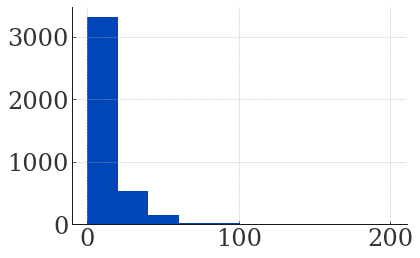

time: 172 ms (started: 2022-08-30 15:08:06 -04:00)


In [ ]:
firstdates_df['ai_start_minmaxdatediff'].hist()


<AxesSubplot:>

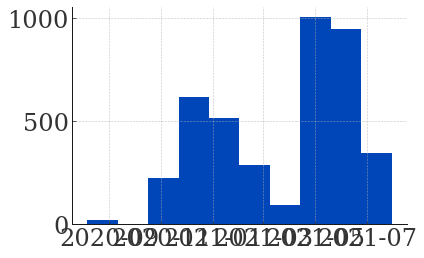

time: 212 ms (started: 2022-08-30 15:08:06 -04:00)


In [ ]:
## Make a graph of when people start

firstdates_df['ai_start_maxdate'].hist()

<AxesSubplot:>

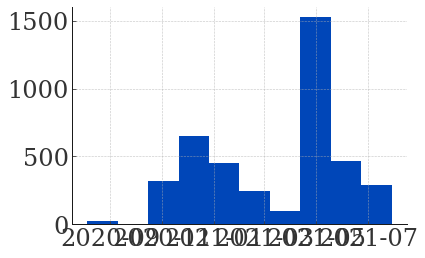

time: 220 ms (started: 2022-08-30 15:08:07 -04:00)


In [ ]:
firstdates_df['ai_start_mindate'].hist()

In [ ]:
prod_df2 = prod_df.merge(firstdates_df.reset_index(), on='latest_agent_id',how='left', indicator=True)
print('Min date merge results: ', prod_df2['_merge'].value_counts())
prod_df2 = prod_df2.drop(columns='_merge')

Min date merge results:  both          1798183
left_only           0
right_only          0
Name: _merge, dtype: int64
time: 17.6 s (started: 2022-08-30 15:08:10 -04:00)


In [ ]:
prod_df2['days_since_ai_start_mindate'] = (prod_df2['chat_date'] - prod_df2['ai_start_mindate']).dt.days
prod_df2['flag_ai_on_mindate'] = 0
prod_df2.loc[prod_df2['days_since_ai_start_mindate']>=1, 'flag_ai_on_mindate'] = 1
print(prod_df2['flag_ai_on_mindate'].describe(), prod_df2['flag_ai_on_mindate'].mean())

count    1.798183e+06
mean     9.831580e-01
std      1.286793e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: flag_ai_on_mindate, dtype: float64 0.9831579989355922
time: 173 ms (started: 2022-08-30 15:08:27 -04:00)


In [ ]:
prod_df2['days_since_ai_start_maxdate'] = (prod_df2['chat_date'] - prod_df2['ai_start_maxdate']).dt.days
prod_df2['flag_ai_on_maxdate'] = 0
prod_df2.loc[prod_df2['days_since_ai_start_maxdate']>=1, 'flag_ai_on_maxdate'] = 1
print(prod_df2['flag_ai_on_maxdate'].describe(), prod_df2['flag_ai_on_maxdate'].mean())

count    1.798183e+06
mean     8.635206e-01
std      3.432970e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: flag_ai_on_maxdate, dtype: float64 0.8635205649258167
time: 160 ms (started: 2022-08-30 15:08:28 -04:00)


In [ ]:
prod_df2['chat_month_date'] = prod_df2['chat_date'].apply(
    lambda x: pd.to_datetime('{}-{}-01'.format(x.year, x.month), format='%Y-%m-%d'))

prod_df2.loc[:, 'chat_month_date'] = prod_df2['chat_month_date'].dt.date

time: 4min 29s (started: 2022-08-30 15:08:28 -04:00)


In [ ]:
## we drop chats that are negative duration over over 120 minutes
to_keep = ((prod_df2['duration_minutes'] >= min_duration) & (prod_df2['duration_minutes']<=max_duration))
print(sum(to_keep))
prod_df3 = prod_df2.loc[to_keep,:]
print(prod_df2.shape, ' Shape after droppping odd duration ', prod_df3.shape)

1731319
(1798183, 69)  Shape after droppping odd duration  (1731319, 69)
time: 3.26 s (started: 2022-08-30 15:47:42 -04:00)


In [ ]:
### Recode some platform_chat_skills that were filled in incorrectly
platform_chat_skill_recode = {'1345878214':'sbseg-dt_proprem_en_us_supp_msg',
                              '1537674214': 'sbseg-dt_diy_en_us_supp_msg',
                              '1697911530': 'sbseg-dt_proprem_en_us_act_msg',
                        '1800521930': 'sbseg-dt_proprem_en_us_plus_msg',
                    '1945457730': 'sbseg-dt_proprem_en_us_suppoutprod_msg',
                '1345878214': 'sbseg-dt_proprem_en_us_supp_msg',
            '1537674214': 'sbseg-dt_diy_en_us_supp_msg', '1697911530': 'sbseg-dt_proprem_en_us_act_msg',
            '1790436730': 'sbseg-dt_diy_en_us_premium_msg',
                        '1709463730': 'sbseg-ol_qbop_en_us_core_msg', '2012060130': 'sbseg-dt_proprem_en_us_plusftu_msg'}


time: 1.12 ms (started: 2022-08-30 15:13:01 -04:00)


In [ ]:
for k, v in platform_chat_skill_recode.items():
    prod_df3.loc[prod_df3['platform_chat_skill']==k, 'platform_chat_skill'] = v

/Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/crestavenv/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


time: 1.72 s (started: 2022-08-30 15:13:01 -04:00)


## Exporting Cleaned production to CSV 
* takes about 5 minutes

In [ ]:
prod_df3.to_csv(cleaned_production_filename)

time: 5min 44s (started: 2022-08-30 15:13:48 -04:00)


## End of the clean production part of the code
* production data cleaning takes much less time than analytics

In [ ]:
##

### Creating Chat Skillname Counts

In [ ]:
post_ai_counts = prod_df3.loc[prod_df3['duration_minutes']>2,:].groupby(['chat_month_date','platform_chat_skill']).agg({'platform_chat_skill': 'count',
                                                                               'duration_minutes': np.mean,
                                                                               'flag_resolved': np.mean})


time: 10.2 s (started: 2022-08-30 15:19:33 -04:00)


In [ ]:
post_ai_counts = post_ai_counts.rename(columns={'platform_chat_skill':'count_chats'}).reset_index()

time: 8.11 ms (started: 2022-08-30 15:19:43 -04:00)


In [ ]:
## add a column that counts the number of months a chat platform skill sticks around
post_ai_counts['number_months'] = post_ai_counts.groupby('platform_chat_skill')['chat_month_date'].transform('count')

time: 11.8 ms (started: 2022-08-30 15:19:43 -04:00)


In [ ]:
## drop if number of chats in a given month-category below a certain threshold
mask = (post_ai_counts['count_chats']>5)
print(sum(mask))
post_ai_counts2 = post_ai_counts.loc[mask, :]
print('Pre filter : ', post_ai_counts.shape, ' post filter ', post_ai_counts2.shape)

827
Pre filter :  (1064, 6)  post filter  (827, 6)
time: 22.6 ms (started: 2022-08-30 15:19:43 -04:00)


In [ ]:
post_ai_counts2['rank_chats'] = post_ai_counts2.groupby(['chat_month_date'])['count_chats'].rank(
    ascending=False, method='min')

time: 32.8 ms (started: 2022-08-30 15:19:43 -04:00)


/Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/crestavenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
post_ai_counts2['rank_duration'] = post_ai_counts2.groupby(['chat_month_date'])['duration_minutes'].rank(
    ascending=True, method='min')


time: 24.5 ms (started: 2022-08-30 15:19:43 -04:00)


/Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/crestavenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
post_ai_counts2['rank_resolution'] = post_ai_counts2.groupby(['chat_month_date'])['flag_resolved'].rank(
    ascending=False, method='min')

time: 22.4 ms (started: 2022-08-30 15:19:43 -04:00)


/Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/crestavenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
## break thse into buckets by month, quarters
#df.groupby('country')[['value']].transform(lambda x: pd.cut(x, bins = 2).astype(str)
post_ai_counts2['quantile_chat_ranks'] = post_ai_counts2.groupby('chat_month_date')[
    'count_chats'].transform(lambda x: pd.qcut(x, q=5, labels=['q0', 'q1', 'q2', 'q3', 'q4']))

time: 163 ms (started: 2022-08-30 15:19:43 -04:00)


/Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/crestavenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
post_ai_counts2['res_per_hour'] = post_ai_counts2['flag_resolved']/(post_ai_counts2['duration_minutes']/60)

time: 7.68 ms (started: 2022-08-30 15:19:43 -04:00)


/Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/CrestaCode/crestavenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Export chat frequency graph

In [ ]:
post_ai_counts2.to_csv(os.path.join(root_dir, 'Data/IntData/chats/chat_ranks.csv'))

time: 83.8 ms (started: 2022-08-30 15:19:44 -04:00)


### Import Analytics Files and Clean

In [ ]:
analytics_files = sorted([x for x in os.listdir(analytics_files_dir) if x.endswith('.csv')])

time: 5.71 ms (started: 2022-08-30 15:19:44 -04:00)


In [ ]:
## import each chat, 


time: 1.28 ms (started: 2022-08-30 16:33:47 -04:00)


time: 2.46 ms (started: 2022-08-30 20:16:15 -04:00)


In [ ]:
def clean_single_analytics(analytics_filepath, clean_filepath, include_text, **kwargs):
    ## import a single analytics file to clean
    print('Reading in :', analytics_filepath)

    analytics_columns = ['analytics_chat_db_id', 'agent_fullname', 'agent_nickname',  'agent_platform_id',  
                             'analytics_chat_name', 'chat_agentdeleted',  'chat_agentfullname',  'chat_agentgroupname', 'chat_agentloginname',
                             'chat_agentnickname',  'chat_closereason', 'chat_closereasondescr', 'chat_duration',  'chat_features',
                             'chat_firstconversation',  'chat_name', 'chat_skillname', 'chat_status', 
                             'chat_text', 'cleaned_platform_chat_id',  'first_agent_platform_id', 'first_nonystem_message',
                             'hermes_chat_id',  'ispartial', 'latest_groupid', 'latest_skillid', 'chat_start_date']
    if not include_text:
        analytics_columns = list(filter(lambda x: x!='chat_text', analytics_columns))
    df = pd.read_csv(analytics_filepath, on_bad_lines='warn', parse_dates=['chat_start_date', 'first_nonystem_message'],
                    usecols=analytics_columns, **kwargs)
    print('Original df shape: ', df.shape)
    df = df.loc[~pd.isnull(df['chat_text'])]
    bool_cols = ['ispartial', 'chat_agentdeleted', 'chat_firstconversation']
    sums = []
    for col in bool_cols:
        r = df.loc[((df[col]==True)|(df[col].isin(['True', 'true', 'TRUE']))), :].shape[0]
        sums.append(r)
    
    df.loc[:, bool_cols] = df.loc[:, bool_cols].applymap(parse_bool)
    for i, col in enumerate(bool_cols):
        print(i, col, df[col].sum() == sums[i])

    df.loc[:, 'chat_duration'] = df['chat_duration'].apply(parse_duration)
    text_analytics_columns = ['analytics_chat_name', 'agent_platform_id','first_agent_platform_id', 'chat_skillname', 'chat_agentfullname',
       'chat_agentnickname', 'chat_agentgroupname', 'chat_agentloginname', 'chat_status', 'chat_closereason', 'chat_closereasondescr', 
       'cleaned_platform_chat_id', 'chat_name','agent_fullname', 'agent_nickname']
    
    df.loc[:, text_analytics_columns] = df.loc[:, text_analytics_columns].applymap(clean_lower_strip_str)

    if include_text:
        df['ana_n_messages_agent'] = df['chat_text'].apply(
                lambda x: len(list(filter(lambda x: x['speaker_role']=='agent', parse_json(x)))))
        df['ana_n_messages_visitor'] = df['chat_text'].apply(
                lambda x: len(list(filter(lambda x: x['speaker_role']=='visitor', parse_json(x)))))
        # filter dataframe -> keep if >1 messages visitor, 1 messages agent,
        # drop chats without agent_id, drop chat_date before August 2020
        print('Subsetting to chats with at least 2 visitor and agent messages: ', df.shape)
        df = df.loc[((df['ana_n_messages_visitor'] > min_messages) & (df['ana_n_messages_agent'] > min_messages)), :]
        print('Shape after subsetting : ', df.shape)
    # now drop rows that are less than or greater min and max duration
    ## we drop chats that are negative duration over over 120 minutes
    to_keep = ((df['chat_duration'] >= min_duration) & (df['chat_duration'] <= max_duration))
    print('Shape after dropping strange durations: ', sum(to_keep))
    df = df.loc[to_keep,:]
    ## filter all platform ids
    
    print('Filtering on platform chat id and agent platform id. Original df: ', df.shape)
    df = df.loc[((~pd.isnull(df['cleaned_platform_chat_id'])) & (~pd.isnull(df['agent_platform_id']))), :]
    mask = ((pd.isnull(df['first_agent_platform_id'])) & (~pd.isnull(df['agent_platform_id'])))
    df.loc[mask, 'first_agent_platform_id'] = df.loc[mask, 'agent_platform_id'].apply(lambda x: x.split('|')[0])
    print('Number missing agent platform ids', df.loc[pd.isnull(df['first_agent_platform_id']),].shape)
    df = df.loc[(~pd.isnull(df['first_agent_platform_id'])), :]
    print(' Filtered df shape : ', df.shape)
    df = df.sort_values('analytics_chat_db_id')
    if 'chat_start_date' in df.columns:
        df.loc[:, 'chat_start_date'] = pd.to_datetime(df['chat_start_date']).dt.date


    assert df.drop_duplicates('analytics_chat_db_id').shape[0] == df.shape[0]
    df = df.set_index('analytics_chat_db_id')
    if include_text:
        print('Creating text columns')
        df['sorted_chat_text']  = df['chat_text'].apply(
            lambda z: sorted(parse_json(z), key=lambda x: pd.to_datetime(x['pub_date'])))
        df['agent_chat_text']  = df['sorted_chat_text'].apply(lambda z: list(map(lambda x: x['chat_text'], filter(lambda x: x[
        'speaker_role']=='agent', z))))
        df['visitor_chat_text']  = df['sorted_chat_text'].apply(lambda z: list(map(lambda x: x['chat_text'], filter(lambda x: x[
        'speaker_role']=='visitor', z))))

    df = df.rename(columns={'cleaned_platform_chat_id':'platform_chat_id', 'chat_start_date': 'chat_start_datetime'})
    assert df['ispartial'].sum() == df.loc[((df['ispartial']=='True') | (df['ispartial']==True)), :].shape[0]
    assert df['chat_firstconversation'].sum() == df.loc[((df['chat_firstconversation']=='True') | (df['chat_firstconversation']==True)), :].shape[0]
    assert df['chat_agentdeleted'].sum() == df.loc[((df['chat_agentdeleted']=='True') | (df['chat_agentdeleted']==True)), :].shape[0]  
    print('Exporting to csv: ', clean_filepath)
    df.to_csv(clean_filepath)
    print('Done exporting to csv')
    return df
    

time: 47.3 ms (started: 2022-08-31 19:51:00 +00:00)


In [ ]:
def clean_analytics(analytics_filesdir, clean_analytics_filesdir, include_text=True, return_dfs=False, **kwargs):
    ana_dfs = []
    analytics_files = sorted([x for x in os.listdir(analytics_filesdir) if x.endswith(
        '.csv') and x.startswith('intuitCS_analytics')])
    for i, f in enumerate(analytics_files):
        if f.endswith('_1.csv') or f.endswith('_2.csv'):
            print('Reading in :', f)
            single_df = clean_single_analytics(os.path.join(analytics_filesdir, f),
                                     os.path.join(clean_analytics_filesdir, f), include_text, **kwargs)
            if return_dfs:
                ana_dfs.append(single_df.copy())
            if not return_dfs:
              del single_df
    if not return_dfs:
        return None
    ana_df = pd.concat(ana_dfs, axis=0)
    print('Concatenated data shape: ', ana_df.shape)
    return ana_df
                 
                    
                         

time: 3.19 ms (started: 2022-08-31 21:17:35 +00:00)


In [ ]:
def load_analytics(clean_analytics_filesdir, include_text=True, **kwargs):
    ana_dfs = []
    analytics_files = sorted([x for x in os.listdir(clean_analytics_filesdir) if x.endswith(
        '.csv') and x.startswith('intuitCS_analytics')])
    for f in analytics_files[:3]:
        print('Reading in :', f)
        single_df = pd.read_csv(os.path.join(clean_analytics_filesdir, f), parse_dates=['chat_start_datetime', 'first_nonystem_message'], **kwargs)
        ana_dfs.append(single_df.copy())
    ana_df = pd.concat(ana_dfs, axis=0)
    print('Concatenated data shape: ', ana_df.shape)
    return ana_df

time: 1.66 ms (started: 2022-08-31 21:17:38 +00:00)


In [ ]:
## this iterates through all analytics files and cleans them 
clean_analytics(analytics_files_dir, clean_analytics_files_dir, include_text=True, return_dfs=False)

Reading in : intuitCS_analytics_12March2022_1.csv
Reading in : /content/drive/MyDrive/Research/Cresta/Data/RawData/chats/analytics_withtext/intuitCS_analytics_12March2022_1.csv
Original df shape:  (551909, 27)
0 ispartial True
1 chat_agentdeleted True
2 chat_firstconversation True
Expecting value: line 1 column 5381 (char 5380) [{"chat_text" : "I cannot use the same email address, right?", "speaker_role" : "visitor", "pub_date" : "2019-11-12T02:59:23"}, {"chat_text" : "I will check on this Ei Ei. Billing history feature has just been recently released and that is still under testing or Beta. I will submit feedback about this to our engineers.", "speaker_role" : "agent", "pub_date" : "2019-11-12T02:27:14"}, {"chat_text" : "No, you can't. You may use a different email to be the company admin.", "speaker_role" : "agent", "pub_date" : "2019-11-12T02:59:59"}, {"chat_text" : "Ok, that's all I think", "speaker_role" : "visitor", "pub_date" : "2019-11-12T03:11:49"}, {"chat_text" : "also can ex

In [ ]:
    analytics_files = sorted([x for x in os.listdir(clean_analytics_filesdir) if x.endswith(
        '.csv') and x.startswith('intuitCS_analytics')])

In [ ]:
orig_prod_user_columns = ['agent_created_at',  'agent_team_id',
 'agent_team_id_agg',  'agent_user_id', 'behaviors_needing_coaching', 'display_name', 'full_name',
    'team_name', 'team_name_agg', 'user_created_at', 'user_id',  'user_platform_id', 'user_role_name',
 'user_role_name_agg', 'user_str_id', 'username']

orig_analytics_user_columns = ['agent_fullname', 'agent_nickname',  'agent_platform_id', 'chat_agentfullname',
 'chat_agentgroupname', 'chat_agentloginname', 'chat_agentnickname']

In [ ]:

to_agg_cols = ['agent_fullname', 'agent_nickname', 'chat_agentgroupname', 'agent_platform_id', 
               'chat_agentnickname', 'chat_agentfullname']


def aggregate_rows(x):
    r = set(list(filter(lambda z: isinstance(z, str), x)))
    if r is None:
        return np.nan
    return '|'.join(list(r))


def collect_analytics_users(clean_analytics_filesdir, **kwargs):
    ana_dfs = []
    analytics_files = sorted([x for x in os.listdir(clean_analytics_filesdir) if x.endswith(
        '.csv') and x.startswith('intuitCS_analytics')])
    for f in analytics_files[:1]:
        print('Reading in :', os.path.join(clean_analytics_filesdir, f))
        single_df = pd.read_csv(os.path.join(clean_analytics_filesdir, f),
                                parse_dates=['chat_start_datetime'], **kwargs)
        single_df['chat_date'] = pd.to_datetime(single_df['chat_start_datetime']).dt.date
        single_df['chat_isoweek_date'] = single_df['chat_date'].apply(lambda x: isoweek.Week.withdate(x).day(ISOWEEK_DAY))
        
        single_df = single_df.loc[~pd.isnull(single_df['first_agent_platform_id']),:]
        single_df['universal_agent_username'] = single_df['first_agent_platform_id'].apply(
            lambda x: x if pd.isnull(x) else x.replace('livepersonagent-',''))
        for col in to_agg_cols:
            single_df[col] = single_df.groupby(['universal_agent_username'])[col].transform(aggregate_rows)

        users_df_ana = single_df[to_agg_cols+['universal_agent_username']].sort_values(['universal_agent_username']+to_agg_cols).drop_duplicates(['universal_agent_username'])
        min_date = single_df.groupby('universal_agent_username')['chat_date'].agg('min').to_frame()
        min_date.columns = ['min_chat_date']
        max_date = single_df.groupby('universal_agent_username')['chat_date'].agg('max').to_frame()
        max_date.columns = ['max_chat_date']
        n_weeks = single_df.groupby('universal_agent_username')['chat_isoweek_date'].agg('count').to_frame()
        n_weeks.columns = ['n_distinct_weeks']
        n_days = single_df.groupby('universal_agent_username')['chat_date'].agg('count').to_frame()
        n_days.columns = ['n_distinct_days']
        to_merge = pd.concat([n_weeks, max_date, min_date, n_days], axis=1, sort=True, join='outer', verify_integrity=True)
        users_df_ana = users_df_ana.merge(to_merge,
                        how='left', left_on='universal_agent_username', right_index=True)
            
        ana_dfs.append(users_df_ana.copy())
    return pd.concat(ana_dfs.columns)

time: 16.8 ms (started: 2022-08-30 22:15:16 -04:00)


In [ ]:
pd.read_csv('/Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/Data/RawData/chats/clean_analytics_withtext/intuitCS_analytics_12March2022_1.csv', nrows=100).columns

Index(['analytics_chat_db_id', 'analytics_chat_name', 'chat_start_datetime',
       'agent_platform_id', 'first_agent_platform_id', 'chat_skillname',
       'chat_agentfullname', 'chat_agentnickname', 'chat_agentgroupname',
       'chat_agentloginname', 'chat_features', 'chat_duration', 'chat_status',
       'ispartial', 'chat_closereason', 'chat_agentdeleted',
       'chat_firstconversation', 'chat_closereasondescr', 'hermes_chat_id',
       'latest_skillid', 'latest_groupid', 'platform_chat_id', 'chat_text',
       'chat_name', 'first_nonystem_message', 'agent_fullname',
       'agent_nickname', 'ana_n_messages_agent', 'ana_n_messages_visitor',
       'sorted_chat_text', 'agent_chat_text', 'visitor_chat_text'],
      dtype='object')

time: 74.2 ms (started: 2022-08-30 22:09:56 -04:00)


In [ ]:
## collect unique users from analytics
users_df_ana = collect_analytics_users(clean_analytics_files_dir)

Reading in : /Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/Data/RawData/chats/clean_analytics_withtext/intuitCS_analytics_12March2022_1.csv


In [ ]:

    

## we do have to worry about multiple groups per anal username
users_df_ana['agent_groupnames_agg'] = users_df_ana.groupby(['universal_agent_username'])['chat_agentgroupname'].transform(aggregate_rows)
users_df_ana['agent_fullname_agg'] = users_df_ana.groupby(['universal_agent_username'])['agent_fullname'].transform(aggregate_rows)
users_df_ana['agent_nickname_agg'] = users_df_ana.groupby(['universal_agent_username'])['agent_nickname'].transform(aggregate_rows)
users_df_ana['agent_platform_id_agg'] = users_df_ana.groupby(['universal_agent_username'])['agent_platform_id'].transform(aggregate_rows)

users_df_ana['chat_agentnickname_agg'] = users_df_ana.groupby(['universal_agent_username'])['chat_agentnickname'].transform(aggregate_rows)
users_df_ana['chat_agentfullname_agg'] = users_df_ana.groupby(['universal_agent_username'])['chat_agentfullname'].transform(aggregate_rows)


users_df_ana = users_df_ana[['universal_agent_username', 'agent_groupnames_agg', 'chat_agentfullname_agg',
                             'chat_agentnickname_agg',
                'agent_fullname_agg', 'agent_nickname_agg', 'agent_platform_id_agg']].drop_duplicates(['universal_agent_username'])


In [ ]:
## check for prod date columns to parse

time: 263 µs (started: 2022-08-30 16:33:54 -04:00)


In [ ]:
prod_datecols = ['chat_isoweek_date',
       'chat_start_datetime', 'chat_date','user_created_at', 'agent_created_at', 'sc_mindate', 'hints_mindate',
       'scoredhints_mindate', 'kb_sugg_mindate', 'sugg_mindate',
       'ai_start_mindate', 'ai_start_maxdate', 'ai_start_minmaxdatediff',
       'days_since_ai_start_mindate', 'flag_ai_on_mindate',
       'days_since_ai_start_maxdate', 'flag_ai_on_maxdate', 'chat_month_date']

# prod_df3 = pd.read_csv(cleaned_production_filename, parse_dates=)

time: 644 µs (started: 2022-08-30 16:33:55 -04:00)


In [ ]:
ana_df = clean_analytics(analytics_files_dir, include_text=True, analytics_columns=analytics_columns, nrows=10000)

Reading in : intuitCS_analytics_12March2022_1.csv
Reading in : /Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cresta/Empirics/Data/RawData/chats/analytics_withtext/intuitCS_analytics_12March2022_1.csv
Original df shape:  (10000, 27)
['analytics_chat_name', 'chat_start_date', 'agent_platform_id', 'first_agent_platform_id', 'chat_skillname', 'chat_agentfullname', 'chat_agentnickname', 'chat_agentgroupname', 'chat_agentloginname', 'chat_status', 'chat_closereason', 'chat_closereasondescr', 'cleaned_platform_chat_id', 'chat_name', 'agent_fullname', 'agent_nickname']
Subsetting to chats with at least 2 visitor and agent messages:  (9995, 29)
Shape after subsetting :  (7943, 29)
Shape after dropping strange durations:  7162
Filtering on platform chat id and agent platform id. Original df:  (7162, 29)
Number missing agent platform ids (0, 29)
 Filtered df shape :  (7162, 29)
Reading in : intuitCS_analytics_12March2022_2.csv
Reading in : /Users/lindseyraymond/Dropbox (MIT)/Research/Erik/Cre

In [ ]:
### make a unique agent_id (agent login )
## combine existing columns into one unique column
## see if amazon connect api missing a lot of informaiton from analytics
## check to see that durations match
## come up with an agent resovled per hour version of the story
## skillname, groupname, 

time: 548 µs (started: 2022-08-30 15:25:22 -04:00)


In [ ]:
print(ana_df['platform_chat_id'].drop_duplicates().shape)
print(ana_df.shape)
assert ana_df['platform_chat_id'].drop_duplicates().shape[0] == ana_df.shape[0]

(21604,)
(21604, 31)
time: 8.5 ms (started: 2022-08-30 16:35:19 -04:00)


In [ ]:
print(prod_df3['platform_chat_id'].drop_duplicates().shape)
print(prod_df3.shape)
assert prod_df3['platform_chat_id'].drop_duplicates().shape[0] == prod_df3.shape[0]

(1731319,)
(1731319, 69)
time: 1.67 s (started: 2022-08-30 16:35:19 -04:00)


In [ ]:
prod_ana_df = prod_df3.merge(
    ana_df, on='platform_chat_id', how='outer', indicator=True, validate='one_to_one', suffixes=['_p', '_a'])

time: 29.9 s (started: 2022-08-30 16:36:23 -04:00)


In [ ]:
print(prod_ana_df['_merge'].value_counts(dropna=False))

left_only     1731319
right_only      21604
both                0
Name: _merge, dtype: int64
time: 12.3 ms (started: 2022-08-30 16:36:53 -04:00)


In [ ]:
prod_ana_df['data_source'] = 'prod'
prod_ana_df.loc[prod_ana_df['_merge']=='right_only', 'data_source'] = 'analytics'
prod_ana_df.loc[prod_ana_df['_merge']=='both', 'data_source'] = 'both'
print(prod_ana_df['data_source'].value_counts())
prod_ana_df = prod_ana_df.drop(columns=['_merge'])

prod         1731319
analytics      21604
Name: data_source, dtype: int64
time: 3.48 s (started: 2022-08-30 16:36:53 -04:00)


In [ ]:
print(prod_ana_df.loc[prod_ana_df['data_source']=='analytics', 'chat_start_datetime_a'].min())
print(prod_ana_df.loc[prod_ana_df['data_source']=='analytics', 'chat_start_datetime_a'].max())
print(prod_ana_df.loc[prod_ana_df['data_source']=='both', 'chat_start_datetime_a'].min())
print(prod_ana_df.loc[prod_ana_df['data_source']=='both', 'chat_start_datetime_a'].max())
print(prod_ana_df.loc[prod_ana_df['data_source']=='prod', 'chat_start_datetime_a'].min())
print(prod_ana_df.loc[prod_ana_df['data_source']=='prod', 'chat_start_datetime_a'].max())

2019-09-01 02:51:53
2020-07-31 22:44:28
NaT
NaT
NaT
NaT
time: 720 ms (started: 2022-08-30 16:36:57 -04:00)


In [ ]:
assert sum(((~pd.isnull(prod_ana_df['hermes_chat_id'])) & (prod_ana_df['hermes_chat_id']!=prod_ana_df['chat_id'])))==0

time: 190 ms (started: 2022-08-30 16:36:57 -04:00)


In [ ]:
## if prod duration is missing, we take analytics duration

ana_mask = (prod_ana_df['data_source'] =='analytics')
both_mask = (prod_ana_df['data_source'] =='both')
prod_ana_df.loc[ana_mask, 'duration_minutes'] = prod_ana_df.loc[ana_mask, 'chat_duration']
both_missing_mask =  (both_mask & (pd.isnull(prod_ana_df['duration_minutes'])))
prod_ana_df.loc[both_missing_mask, 'duration_minutes'] = prod_ana_df.loc[both_missing_mask, 'chat_duration']
prod_ana_df['temp'] = prod_ana_df['duration_minutes'] - prod_ana_df['chat_duration']
prod_ana_df.loc[:, 'temp'] = prod_ana_df['temp'].fillna(0)
print('Overlap', sum(both_mask))
print('Number that differ by more than ten :', prod_ana_df.loc[(both_mask & (np.abs(prod_ana_df['temp'])>10)),: ].shape)

Overlap 0
Number that differ by more than ten : (0, 101)
time: 1.08 s (started: 2022-08-30 16:37:14 -04:00)


In [ ]:
prod_ana_df = prod_ana_df.drop(columns=['chat_duration', 'temp'])

time: 1.45 s (started: 2022-08-30 16:37:15 -04:00)


In [ ]:
prod_ana_df.loc[ana_mask, 'platform_chat_skill'] = prod_ana_df.loc[ana_mask, 'chat_skillname']
                                                               
both_missing_mask =  (both_mask & (pd.isnull(prod_ana_df['platform_chat_skill'])))
prod_ana_df.loc[both_missing_mask, 'platform_chat_skill'] = prod_ana_df.loc[both_missing_mask, 'chat_skillname']
prod_ana_df['temp'] = prod_ana_df['platform_chat_skill']!=prod_ana_df['chat_skillname']
prod_ana_df.loc[:, 'temp'] = prod_ana_df['temp'].astype(int).fillna(0)
print('Overlap', sum(both_mask))
print('Number that differ :', prod_ana_df.loc[(both_mask & (np.abs(prod_ana_df['temp'])>0)),: ].shape)


Overlap 0
Number that differ : (0, 100)
time: 505 ms (started: 2022-08-30 16:37:16 -04:00)


In [ ]:
## check if any missing in prod that have a chat_skill id from analytics
print('Are there any chat skills ids that we can use?')
print(prod_ana_df.loc[both_missing_mask , 'latest_skillid'].value_counts(dropna=False))
prod_ana_df.loc[both_missing_mask, 'platform_chat_skill'] = prod_ana_df.loc[both_missing_mask, 'latest_skillid']
print('Now recoding skillids to skill names')
for k, v in platform_chat_skill_recode.items():
    prod_ana_df.loc[prod_ana_df['platform_chat_skill']==k, 'platform_chat_skill'] = v

Are there any chat skills ids that we can use?
Series([], Name: latest_skillid, dtype: int64)
Now recoding skillids to skill names
time: 1.42 s (started: 2022-08-30 16:37:17 -04:00)


In [ ]:
prod_ana_df = prod_ana_df.drop(columns=['chat_skillname', 'latest_skillid', 'temp'])


time: 1.43 s (started: 2022-08-30 16:37:18 -04:00)


In [ ]:
## now combine chat_start_datetime
prod_ana_df.loc[:, 'chat_start_datetime_p'] = prod_ana_df['chat_start_datetime_p'].dt.tz_localize(None)
prod_ana_df['chat_start_datetime'] = prod_ana_df['chat_start_datetime_p']
prod_ana_df.loc[ana_mask, 'chat_start_datetime'] = prod_ana_df.loc[ana_mask, 'chat_start_datetime_a']
prod_ana_df.loc[(both_mask & (pd.isnull(prod_ana_df[
    'chat_start_datetime']))), 'chat_start_datetime'] = prod_ana_df.loc[(both_mask & (pd.isnull(
        prod_ana_df['chat_start_datetime']))), 'chat_start_datetime_a']

time: 56.6 ms (started: 2022-08-30 16:37:20 -04:00)


In [ ]:
prod_ana_df.loc[:, 'chat_start_datetime'] = pd.to_datetime(prod_ana_df.loc[:, 'chat_start_datetime'])

time: 26.2 ms (started: 2022-08-30 16:37:20 -04:00)


In [ ]:
prod_ana_df['temp'] = np.abs(prod_ana_df['chat_start_datetime_a'] - prod_ana_df['chat_start_datetime_p'])
prod_ana_df.loc[prod_ana_df['temp'] < np.timedelta64(10, 'M'), 'temp'] = 0
prod_ana_df.loc[:, 'temp'] =prod_ana_df['temp'].fillna(0)
print(prod_ana_df.loc[prod_ana_df['temp']>0, :].shape)

(0, 99)
time: 6.13 s (started: 2022-08-30 16:37:22 -04:00)


In [ ]:
prod_ana_df = prod_ana_df.drop(columns=['chat_start_datetime_a', 'chat_start_datetime_p', 'temp', 'first_nonystem_message',])

time: 1.56 s (started: 2022-08-30 16:37:28 -04:00)


In [ ]:
### Fill in date columns for rows from ana
mask = pd.isnull(prod_ana_df['chat_date'])
prod_ana_df.loc[mask, 'chat_date'] = prod_ana_df.loc[mask, 'chat_start_datetime'].dt.date

time: 37.4 ms (started: 2022-08-30 16:37:29 -04:00)


In [ ]:
prod_ana_df.loc[:, 'chat_month_date'] = pd.to_datetime(prod_ana_df.loc[:,'chat_month_date'])

time: 1.17 s (started: 2022-08-30 16:37:29 -04:00)


In [ ]:
mask = pd.isnull(prod_ana_df['chat_month_date'])
prod_ana_df.loc[mask, 'chat_month_date'] = prod_ana_df.loc[mask, 'chat_date'].apply(
    lambda x: pd.to_datetime('{}-{}-01'.format(x.year, x.month), format='%Y-%m-%d').date)

time: 18.1 s (started: 2022-08-30 16:37:31 -04:00)


In [ ]:
prod_ana_df.loc[:, 'chat_isoweek_date'] = pd.to_datetime(prod_ana_df.loc[:, 'chat_isoweek_date']).dt.date

time: 933 ms (started: 2022-08-30 16:37:49 -04:00)


In [ ]:
mask = pd.isnull(prod_ana_df['chat_isoweek_date'])

time: 96.6 ms (started: 2022-08-30 16:37:50 -04:00)


In [ ]:
prod_ana_df.loc[mask, 'chat_isoweek_date']= prod_ana_df.loc[mask, 'chat_start_datetime'].apply(
    lambda x: isoweek.Week.withdate(x).day(ISOWEEK_DAY))

time: 273 ms (started: 2022-08-30 16:37:50 -04:00)


In [ ]:
## amazon connect analytics do have hermes_id (production chats.id) in the analytics table
## agent_platform_ids is a json field with multiple possible values
## this corresponds to the users.username in the production database with livepersonagent- appended. 
# {livepersonagent-megan.beverly@sykes.com} for chat id 5205265 in analytics and username megan.beverly@sykes.com in app.users.prod
# this holds true for messages that go through amazon-connect and liveperson
# platform_id in app.chats in production should match chat_name in analytics if we append 'liveperson-'
# for example platform id 8b84ca8f-0899-4526-b077-6285faf76ced becomes liveperson-8b84ca8f-0899-4526-b077-6285faf76ced


time: 1.18 ms (started: 2022-08-30 16:37:50 -04:00)


In [ ]:
prod_ana_df['universal_agent_username'] = prod_ana_df['username']
prod_ana_df.loc[ana_mask, 'universal_agent_username'] = prod_ana_df.loc[ana_mask,'first_agent_platform_id'].apply(
    lambda x: x if pd.isnull(x) else x.replace('livepersonagent-',''))

time: 124 ms (started: 2022-08-30 16:37:50 -04:00)


In [ ]:
assert sum(pd.isnull(prod_ana_df['universal_agent_username']))==0

time: 322 ms (started: 2022-08-30 16:37:50 -04:00)


time: 1.84 ms (started: 2022-08-30 19:43:27 -04:00)


In [ ]:
## for each user, calculate first date, last date, flag if present in prod, flag if present in analytics

time: 340 µs (started: 2022-08-30 19:43:28 -04:00)


In [ ]:
# we don't have to worry about multiple values for the same username here

time: 238 µs (started: 2022-08-30 19:43:28 -04:00)


In [ ]:
users_df_prod = prod_ana_df.loc[prod_ana_df['data_source']=='prod', orig_prod_user_columns+[
    'universal_agent_username']].sort_values(['universal_agent_username'], na_position='last').drop_duplicates('universal_agent_username')

time: 4.91 s (started: 2022-08-30 19:43:28 -04:00)


In [ ]:
## create universal full name, user_id, user_role_name, username
users_df_prod = users_df_prod.rename(columns={x:'{}_prod'.format(x) for x in orig_prod_user_columns})

time: 4.73 ms (started: 2022-08-30 19:43:33 -04:00)


In [ ]:
def 

In [ ]:
users_df_ana = prod_ana_df.loc[prod_ana_df['data_source']=='analytics', orig_analytics_user_columns+[
    'universal_agent_username']].sort_values(['universal_agent_username', 'agent_fullname',
                    'agent_nickname', 'chat_agentgroupname', 'agent_platform_id']).drop_duplicates(
    ['universal_agent_username', 'agent_fullname',
                    'agent_nickname', 'chat_agentgroupname', 'agent_platform_id', 'chat_agentnickname', 'chat_agentfullname'])


def aggregate_rows(x):
    r = set(list(filter(lambda z: isinstance(z, str), x)))
    if r is None:
        return np.nan
    return '|'.join(list(r))
    

## we do have to worry about multiple groups per anal username
users_df_ana['agent_groupnames_agg'] = users_df_ana.groupby(['universal_agent_username'])['chat_agentgroupname'].transform(aggregate_rows)
users_df_ana['agent_fullname_agg'] = users_df_ana.groupby(['universal_agent_username'])['agent_fullname'].transform(aggregate_rows)
users_df_ana['agent_nickname_agg'] = users_df_ana.groupby(['universal_agent_username'])['agent_nickname'].transform(aggregate_rows)
users_df_ana['agent_platform_id_agg'] = users_df_ana.groupby(['universal_agent_username'])['agent_platform_id'].transform(aggregate_rows)

users_df_ana['chat_agentnickname_agg'] = users_df_ana.groupby(['universal_agent_username'])['chat_agentnickname'].transform(aggregate_rows)
users_df_ana['chat_agentfullname_agg'] = users_df_ana.groupby(['universal_agent_username'])['chat_agentfullname'].transform(aggregate_rows)


users_df_ana = users_df_ana[['universal_agent_username', 'agent_groupnames_agg', 'chat_agentfullname_agg',
                             'chat_agentnickname_agg',
                'agent_fullname_agg', 'agent_nickname_agg', 'agent_platform_id_agg']].drop_duplicates(['universal_agent_username'])


time: 301 ms (started: 2022-08-30 19:43:33 -04:00)


In [ ]:
users_df = users_df_prod.merge(
    users_df_ana, on='universal_agent_username', how='outer', validate='one_to_one', indicator=True)

time: 57 ms (started: 2022-08-30 19:43:41 -04:00)


In [ ]:
users_df['_merge'].value_counts(dropna=False)

left_only     3912
right_only    2063
both            75
Name: _merge, dtype: int64

time: 4.17 ms (started: 2022-08-30 19:43:41 -04:00)


In [ ]:
prod_user_columns = ['agent_created_at',  'agent_team_id',
 'agent_team_id_agg',  'agent_user_id', 'behaviors_needing_coaching', 'display_name', 'full_name',
    'team_name', 'team_name_agg', 'user_created_at', 'user_id',  'user_platform_id', 'user_role_name',
 'user_role_name_agg', 'user_str_id', 'username']

analytics_user_columns = ['agent_groupnames_agg', 'chat_agentfullname_agg',
                             'chat_agentnickname_agg',
                'agent_fullname_agg', 'agent_nickname_agg', 'agent_platform_id_agg']

time: 825 µs (started: 2022-08-30 19:43:41 -04:00)


In [ ]:
users_df.loc[mask, 'agent_fullname_agg']

Series([], Name: agent_fullname_agg, dtype: object)

time: 3.26 ms (started: 2022-08-30 19:43:41 -04:00)


In [ ]:
# fill in full name
users_df['full_name'] = users_df['full_name_prod']
mask = (pd.isnull(users_df['full_name_prod']) & (~pd.isnull(users_df['agent_fullname_agg'])))
print('Filling in with ana value :', sum(mask))
users_df.loc[mask, 'full_name'] = users_df.loc[mask, 'agent_fullname_agg'].apply(lambda x: x.split('|')[0])

mask = (pd.isnull(users_df['full_name']) & (~pd.isnull(users_df['chat_agentfullname_agg'])))
print('Filling in with ana value from agent :', sum(mask))
users_df.loc[mask, 'full_name'] = users_df.loc[mask, 'chat_agentfullname_agg'].apply(lambda x: x.split('|')[0])


Filling in with ana value : 2063
Filling in with ana value from agent : 0
time: 12.8 ms (started: 2022-08-30 19:43:41 -04:00)


In [ ]:
to_drop = ['chat_agentfullname_ana', 'agent_fullname_ana', 'full_name_prod',
           'agent_nickname_ana', 'display_name_prod', 'chat_agentnickname']

time: 560 µs (started: 2022-08-30 19:43:41 -04:00)


In [ ]:
## fill in agent_display name which is the same as display_name in prod
users_df['agent_display_name'] = users_df['display_name_prod']
mask = (pd.isnull(users_df['agent_display_name']) & (~pd.isnull(users_df['agent_nickname_agg'])))
print('Filling in with ana value :', sum(mask))
users_df.loc[mask, 'agent_display_name'] = users_df.loc[mask, 'agent_nickname_agg'].apply(lambda x: x.split('|')[0])

mask = (pd.isnull(users_df['agent_display_name']) & (~pd.isnull(users_df['chat_agentnickname_agg'])))
print('Filling in with ana value from agent :', sum(mask))
users_df.loc[mask, 'agent_display_name'] = users_df.loc[mask, 'chat_agentnickname_agg'].apply(lambda x: x.split('|')[0])




Filling in with ana value : 2063
Filling in with ana value from agent : 0
time: 13.1 ms (started: 2022-08-30 19:43:41 -04:00)


In [ ]:
min_date = prod_ana_df.groupby('universal_agent_username')['chat_date'].agg('min').to_frame()
min_date.columns = ['min_chat_date']
max_date = prod_ana_df.groupby('universal_agent_username')['chat_date'].agg('max').to_frame()
max_date.columns = ['max_chat_date']
n_weeks = prod_ana_df.groupby('universal_agent_username')['chat_isoweek_date'].agg('count').to_frame()
n_weeks.columns = ['n_distinct_weeks']

users_df = users_df.merge(n_weeks,
                        how='left', left_on='universal_agent_username', right_index=True)
users_df = users_df.merge(max_date,
                        how='left', left_on='universal_agent_username', right_index=True)
users_df = users_df.merge(min_date,
                        how='left', left_on='universal_agent_username', right_index=True)

time: 445 ms (started: 2022-08-30 19:43:43 -04:00)


In [ ]:
users_df = users_df.drop(columns=['_merge'])

time: 12.5 ms (started: 2022-08-30 19:44:09 -04:00)


In [ ]:
## merge these back to the dataframe,drop uder columns from datagrame
## create first and last seen date
## create 

In [ ]:
# append/merge analytics to production with platform_id
# create user_agent, chat_date, resolved, duration for chats not matched to production
# check kpi results to resolved chats
# merge in chat groupname from analytics

    

In [ ]:
### instead of redownloading data from analytics, we are going to use the existing analytics filepulls

In [ ]:
### Nice graph of the 

In [ ]:
post_ai_counts['chat_month_date'].drop_duplicates()

In [ ]:
for month in post_ai_counts['chat_month_date'].unique():
    print(month)
    post_ai_counts.loc[post_ai_counts['chat_month_date']==month,: ]

In [ ]:
data=post_ai_counts.loc[post_ai_counts['chat_month_date']==pd.to_datetime('2020-08-01').date(),: ]

In [ ]:
binsreg.binsreg(x='count_chats', y='duration_minutes', data=data)

In [ ]:
fig, axes = plt.subplots(1)
axes.binscatter(data['count_chats'], data['duration_minutes'])

In [ ]:
### Create date when agent first receives AI output
## Create 

### Add hints

In [ ]:
### Add user information

In [ ]:
df4.head()

In [ ]:
users_df.head()